# 資料前處理

In [ ]:
from pathlib import Path

src = Path('dataset-resized')
dest = Path('dataset-resized/dataset-resized')

classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
class_map = {c: i for i, c in enumerate(classes)}

In [ ]:
!wget "https://huggingface.co/datasets/garythung/trashnet/resolve/main/dataset-resized.zip" -O {src}.zip
!unzip -o {src}.zip "dataset-resized/*" -d {src}

--2025-05-30 15:46:07--  https://huggingface.co/datasets/garythung/trashnet/resolve/main/dataset-resized.zip
Resolving huggingface.co (huggingface.co)... 18.164.174.23, 18.164.174.118, 18.164.174.55, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.23|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/76/6b/766b5d3fa3b4c589999f763b2dbbf7b7d8f28f754336cf4c836b1e91f7535b63/c060e8abfe5d6de0578ca15be1ed8ad0794a865d333c3473d53d1d9ad6e38b8c?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27dataset-resized.zip%3B+filename%3D%22dataset-resized.zip%22%3B&response-content-type=application%2Fzip&Expires=1748623567&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0ODYyMzU2N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy83Ni82Yi83NjZiNWQzZmEzYjRjNTg5OTk5Zjc2M2IyZGJiZjdiN2Q4ZjI4Zjc1NDMzNmNmNGM4MzZiMWU5MWY3NTM1YjYzL2MwNjBlOGFiZmU1ZDZkZTA1NzhjYTE1YmUxZWQ4YWQwNzk0YTg2NWQzMz

In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(15),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=dest.absolute(), transform=transform)

In [ ]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 模型訓練

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0

  train_correct = 0
  train_total = 0

  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)

    _, predicted = torch.max(outputs.data, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

  epoch_loss = running_loss / len(train_dataset)
  epoch_acc = train_correct / train_total

  # 模型驗證
  model.eval()
  val_correct = 0
  val_total = 0

  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, predicted = torch.max(outputs.data, 1)
      val_total += labels.size(0)
      val_correct += (predicted == labels).sum().item()

  val_acc = val_correct / val_total

  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}')

  if val_acc > best_val_acc:
    best_val_acc = val_acc
    torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/10, Loss: 1.2620, Train Acc: 0.5260, Val Acc: 0.4380
Epoch 2/10, Loss: 1.0208, Train Acc: 0.6182, Val Acc: 0.4063
Epoch 3/10, Loss: 0.8471, Train Acc: 0.6844, Val Acc: 0.5726
Epoch 4/10, Loss: 0.7663, Train Acc: 0.7087, Val Acc: 0.6306
Epoch 5/10, Loss: 0.6528, Train Acc: 0.7788, Val Acc: 0.7520
Epoch 6/10, Loss: 0.6312, Train Acc: 0.7681, Val Acc: 0.6966
Epoch 7/10, Loss: 0.5710, Train Acc: 0.7879, Val Acc: 0.7361
Epoch 8/10, Loss: 0.5298, Train Acc: 0.8026, Val Acc: 0.7150
Epoch 9/10, Loss: 0.5143, Train Acc: 0.8179, Val Acc: 0.7177
Epoch 10/10, Loss: 0.5208, Train Acc: 0.8184, Val Acc: 0.7414


# 模型評估

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
  for inputs, labels in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.86      0.91      0.88        54
       glass       0.79      0.82      0.80        85
       metal       0.76      0.88      0.82        60
       paper       0.90      0.78      0.84        88
     plastic       0.83      0.75      0.79        71
       trash       0.65      0.68      0.67        22

    accuracy                           0.81       380
   macro avg       0.80      0.80      0.80       380
weighted avg       0.82      0.81      0.81       380



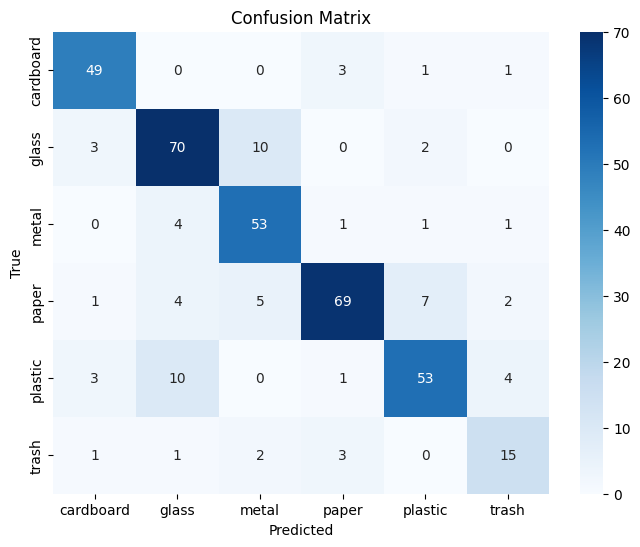

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 資料預測

# 完整的模型

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import random_split, DataLoader
from PIL import Image

def load_dataset(dataset_path):
  train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)

  train_size = int(0.7 * len(dataset))
  val_size = int(0.15 * len(dataset))
  test_size = len(dataset) - train_size - val_size

  train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

  val_dataset.transform = eval_transform
  test_dataset.transform = eval_transform

  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

  return train_loader, val_loader, test_loader

class TrashClassifier:
  def __init__(self, model_path=None):
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    self.classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

    self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    self.model.to(self.device)

    if model_path:
      self.model.load_state_dict(torch.load(model_path, map_location=self.device))
      self.model.eval()

  def load_datasets(self, dataset_path):
    self.train_loader, self.val_loader, self.test_loader = load_dataset(dataset_path)

  def train(self, epochs=10, learning_rate=1e-3, save_path='best.pth', patience=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(epochs):
      self.model.train()

      train_correct = 0
      train_total = 0

      for inputs, labels in self.train_loader:
        inputs = inputs.to(self.device)
        labels = labels.to(self.device)

        optimizer.zero_grad()
        outputs = self.model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

      epoch_acc = train_correct / train_total

      # 驗證模型
      self.model.eval()

      val_correct = 0
      val_total = 0

      with torch.no_grad():
        for inputs, labels in self.val_loader:
          inputs = inputs.to(self.device)
          labels = labels.to(self.device)

          outputs = self.model(inputs)

          _, predicted = torch.max(outputs.data, 1)
          val_total += labels.size(0)
          val_correct += (predicted == labels).sum().item()

      val_acc = val_correct / val_total

      print(f'Epoch {epoch+1}/{epochs}, Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}')

      if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(self.model.state_dict(), save_path)
        patience_counter = 0
      else:
        patience_counter += 1

        if patience_counter >= patience:
          print('Early stopping triggered.')
          break

  def evaluate(self):
    self.model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
      for inputs, labels in self.test_loader:
        inputs = inputs.to(self.device)
        outputs = self.model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

  def predict(self, img):
    self.model.eval()

    image = img.convert('RGB')

    eval_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = eval_transform(image).unsqueeze(0).to(self.device) # type: ignore

    with torch.no_grad():
      output = self.model(image_tensor)

      prob = nn.functional.softmax(output, dim=1)
      confidence, label = torch.max(prob, 1)

    return self.classes[label.item()], confidence.item() # type: ignore


In [ ]:
classifier = TrashClassifier()
classifier.load_datasets(dest.absolute())

classifier.train(epochs=20)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 70.1MB/s]


Epoch 1/20, Train Acc: 0.5515, Val Acc: 0.6095
Epoch 2/20, Train Acc: 0.6821, Val Acc: 0.6755
Epoch 3/20, Train Acc: 0.7257, Val Acc: 0.5752
Epoch 4/20, Train Acc: 0.7800, Val Acc: 0.7546
Epoch 5/20, Train Acc: 0.7822, Val Acc: 0.8021
Epoch 6/20, Train Acc: 0.8179, Val Acc: 0.8100
Epoch 7/20, Train Acc: 0.8422, Val Acc: 0.8153
Epoch 8/20, Train Acc: 0.8354, Val Acc: 0.8074
Epoch 9/20, Train Acc: 0.8422, Val Acc: 0.7678
Epoch 10/20, Train Acc: 0.8801, Val Acc: 0.8206
Epoch 11/20, Train Acc: 0.8739, Val Acc: 0.7863
Epoch 12/20, Train Acc: 0.8597, Val Acc: 0.8100
Epoch 13/20, Train Acc: 0.8931, Val Acc: 0.8470
Epoch 14/20, Train Acc: 0.9146, Val Acc: 0.8522
Epoch 15/20, Train Acc: 0.8999, Val Acc: 0.8100
Epoch 16/20, Train Acc: 0.8988, Val Acc: 0.7889
Epoch 17/20, Train Acc: 0.8976, Val Acc: 0.8047
Epoch 18/20, Train Acc: 0.9202, Val Acc: 0.8443
Epoch 19/20, Train Acc: 0.9152, Val Acc: 0.8443
Early stopping triggered.


Classification Report:
              precision    recall  f1-score   support

   cardboard       1.00      0.98      0.99        60
       glass       0.98      0.85      0.91        74
       metal       0.91      0.97      0.94        71
       paper       0.93      0.95      0.94        85
     plastic       0.93      0.89      0.91        72
       trash       0.64      0.89      0.74        18

    accuracy                           0.93       380
   macro avg       0.90      0.92      0.91       380
weighted avg       0.93      0.93      0.93       380



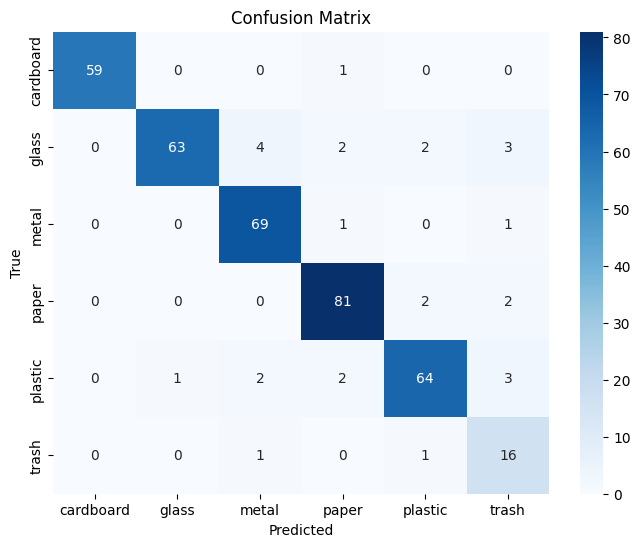

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

classifier = TrashClassifier('/content/best (1).pth')
classifier.load_datasets(dest.absolute())

all_labels, all_preds = classifier.evaluate()

print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes, yticklabels=classifier.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from PIL import Image

classifier = TrashClassifier('/content/best (1).pth')
label, confidence = classifier.predict(Image.open('/content/phpTfGCQu.jpg'))
label, confidence

('plastic', 0.9988688826560974)